# Ejercicio de Random Forest
Realizaremos un ejercicio de prueba para comprender como funciona este algoritmo

Random Forest es un tipo de Ensamble en Machine Learning en donde combinaremos diversos árboles -ya veremos cómo y con qué características- y la salida de cada uno se contará como “un voto” y la opción más votada será la respuesta del "Bosque Aleatorio".

Random Forest, al igual que el árbol e decisión, es un modelo de aprendizaje supervisado para clasificación (aunque también puede usarse para problemas de regresión).

## ¿Cómo funciona Random Forest?
Random Forest funciona así:

* Seleccionamos __k features__ (columnas) de las __m totales__ (siendo k menor a m) y creamos un árbol de decisión con esas k características.
* Creamos __n árboles__ variando siempre la cantidad de k features y también podríamos variar la cantidad de muestras que pasamos a esos árboles (esto es conocido como “bootstrap sample”)
* Tomamos cada uno de los n árboles y le pedimos que hagan una misma clasificación. Guardamos el resultado de cada árbol obteniendo n salidas.
* Calculamos los votos obtenidos para cada “clase” seleccionada y consideraremos a la más votada como la clasificación final de nuestro “bosque”.

## Ventajas y Desventajas
Ventajas

* Funciona bien -aún- sin ajuste de hiperparámetros
* Funciona bien para problemas de clasificación y también de regresión.
* Al utilizar múltiples árboles se reduce considerablemente el riesgo de overfiting
* Se mantiene estable con nuevas muestras puesto que al utilizar cientos de árboles sigue prevaleciendo el promedio de sus votaciones.

Desjeventajas:

* En algunos datos de entrada “particulares” random forest también puede caer en overfitting
* Es mucho más “costo” de crear y ejecutar que “un sólo árbol” de decisión.
* Puede requerir muchísimo tiempo de entrenamiento
* OJO! Random Forest no funciona bien con datasets pequeños.
* Es muy difícil poder interpretar los ¿cientos? de árboles creados en el bosque, si quisiéramos comprender y explicar a un cliente su comportamiento.

# Objetivo
__En este notebook intentaremos predecir si un cliente de un banco es normal o realizó fraude con su tarjeta de crédito__

Contamos con un dataset de 284807 filas y 31 columnas de características. Nuestra salida será 0 si es un cliente “normal” o 1 si hizo uso fraudulento.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams
from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

## Cargamos Datos

In [2]:
# Si no viene adjunto el csv a este ejercicio, descargar desde https://www.kaggle.com/mlg-ulb/creditcardfraud/data
df = pd.read_csv("creditcard.csv")
df.head(n=5) 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(df.shape)

(284807, 31)


## Vemos Desbalanceo
Vemos que son 284.807 filas y solamente 492 son la clase minoritaria con los casos de fraude. Representan el 0,17% de las muestras.

In [4]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

0    284315
1       492
Name: Class, dtype: int64

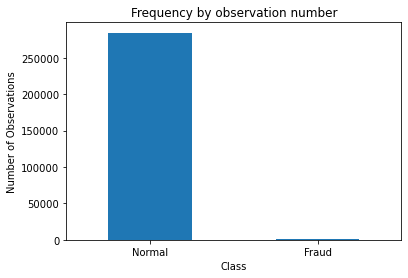

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

¿Llegas a ver la mínima linea roja que representa los casos de Fraude? son muy pocas muestras!

In [6]:
normal_df = df[df.Class == 0] #registros normales
fraud_df = df[df.Class == 1] #casos de fraude

## Creamos Dataset

In [7]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [8]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

## Ejecutamos Modelo con LogisticRegresion para poder Comparar, es decir, el modelo a secas, sin estrategias

In [9]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line 

### Veamos como responde en el test set

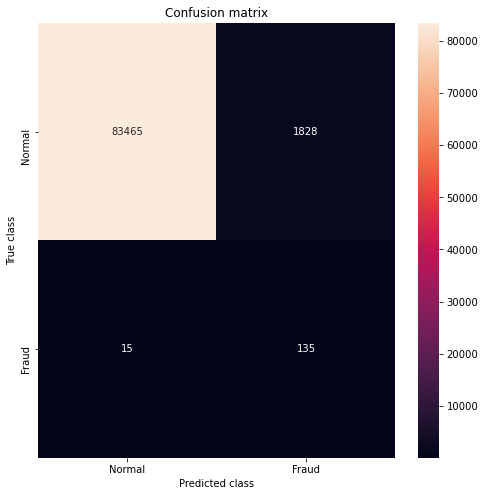

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85293
           1       0.07      0.90      0.13       150

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [10]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Aqui vemos la confusion matrix y en la clase 2 (es lo que nos interesa detectar) vemos 11 fallos y 128 aciertos (la segunda fila del gráfico) dando un recall de 0.92 (normalmente saldrá un valor mucho más bajo) y es el valor que queremos mejorar. También es interesante notar que en la columna de f1-score obtenemos muy buenos resultados PERO que realmente no nos deben engañar… pues están reflejando una realidad parcial. Lo cierto es que nuestro modelo no es capaz de detectar correctamente los casos de Fraude.

# Probamos con Random Forest

Al momento de ajustar el modelo, debemos tener en cuenta los siguientes hiperparámetros. Estos nos ayudarán a que el bosque de mejores resultados para cada ejercicio. 

* __n_estimators__: será la cantidad de árboles que generaremos.
* __max_features__: la manera de seleccionar la cantidad máxima de features para cada árbol.
* __min_sample_leaf__: número mínimo de elementos en las hojas para permitir un nuevo split (división) del nodo.
* __oob_score__: es un método que emula el cross-validation en árboles y permite mejorar la precisión y evitar overfitting.
* __boostrap__: para utilizar diversos tamaños de muestras para entrenar. Si se pone en falso, utilizará siempre el dataset completo.
* __n_jobs__: si tienes multiples cores en tu CPU, puedes indicar cuantos puede usar el modelo al entrenar para acelerar el entrenamiento.

## ATENCION: Este modelo toma algo más de tiempo en entrenar

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo con 100 arboles
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,verbose=2,
                               max_features = 'sqrt')
# entrenar!
model.fit(X_train, y_train)

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(max_features='sqrt', verbose=2)

### Revisemos los resultados

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


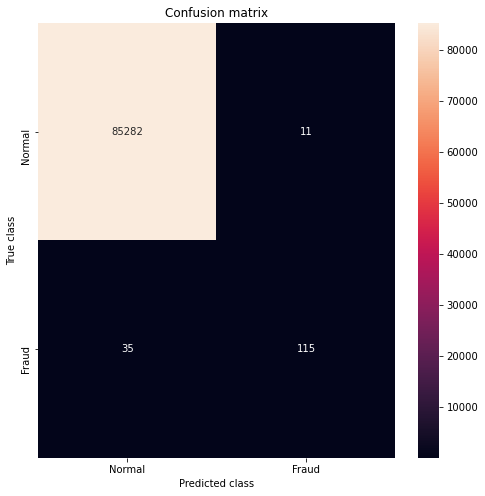

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.91      0.77      0.83       150

    accuracy                           1.00     85443
   macro avg       0.96      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [12]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Vemos muy buenos resultados, clasificando con error apenas 6 + 28 muestras.

Aquí podemos destacar que para la clase “minoritaria”, es decir la que detecta los casos de fraude tenemos un buen valor de recall (de 0.81) lo cual es un buen indicador! y el F1-score macro avg es de 0.94. Logramos construir un modelo de Bosque aleatorio que a pesar de tener un conjunto de datos de entrada muy desigual, logra buenos resultados.

# Otro Bosque: Random Forest -más veloz-

In [13]:
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=2, max_depth=6,
                               oob_score=True, random_state=50)
# a entrenar
model.fit(X_train, y_train)

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   40.8s finished


RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_features='sqrt', oob_score=True, random_state=50,
                       verbose=2)

## Veamos la Confusion Matrix con el conjunto de Test

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


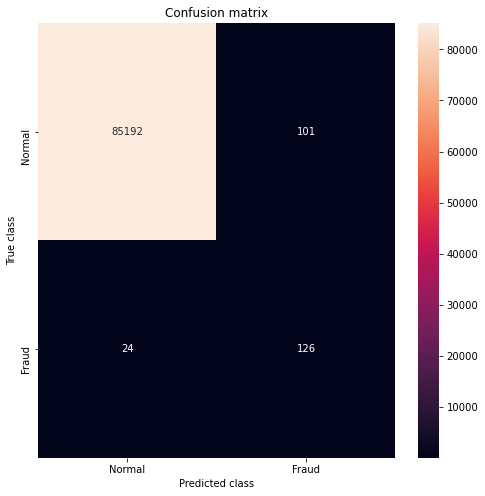

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.56      0.84      0.67       150

    accuracy                           1.00     85443
   macro avg       0.78      0.92      0.83     85443
weighted avg       1.00      1.00      1.00     85443



In [14]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Comprobamos Resultados

In [15]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)

In [16]:
print(roc_value)

0.9194079232762359


El valor de roc cuanto más cerca de 1, mejor. si fuera 0.5 daría igual que fuesen valores aleatorios y sería un mal modelo